In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import gensim
from gensim.models import Word2Vec
from tqdm.auto import tqdm
from plotly.subplots import make_subplots
import plotly.io as pio
from utils import *
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

tqdm.pandas()


## Load embeddings

In [3]:
key_to_index = load_key_to_index()
dw2v_embeddings = pd.read_pickle("trained_models/dw2v/5_year_interval/emb_300/L10T50G100A1ngV_iter9.p")



In [4]:
dw2v_embeddings_kw = []
for embedding in dw2v_embeddings:
    kw = gensim.models.KeyedVectors(vector_size=300)
    kw.add_vectors(list(key_to_index.keys()),embedding)
    dw2v_embeddings_kw.append(kw)

In [5]:
## INPUTS
INTERVAL = [1867, 1920, 1950, 1980, 1995, 2010, 2022]
#Generate inteverals based on input
interval_range = [range(x[0],x[1]) for x in zip(INTERVAL[:-1],INTERVAL[1:])] 
timespans = list(zip(INTERVAL[:-1],INTERVAL[1:]))
aw2v_embeddings = []
timespans_str = []
for timespan in tqdm(timespans):
    timespans_str.append(f"{timespan[0]}_{timespan[1]-1}")
    model = Word2Vec.load(f"trained_models/aw2v/aligned/{timespan[0]}_{timespan[1]-1}_w2v.pkl")
    aw2v_embeddings.append(model.wv)


100%|██████████| 6/6 [00:02<00:00,  2.48it/s]


# Visualisations

### Two-dimensional embeddings

#### Only DW2V

In [6]:
from utils import *

gode_ord = ["landbrug","sex","fod","stande","stoffer"]
title_prefix = "Query word - "
query_word_1 = "sex"
query_word_2 = "mand"
query_word_3 = "imødegå"
query_word_4 = "overfald"

subplot_titles = [f"{title_prefix}{query_word_1}, DW2V",
                   f"{title_prefix}{query_word_2}, DW2V",
                   f"{title_prefix}{query_word_3}, DW2V",
                   f"{title_prefix}{query_word_4}, DW2V"]
top_n_words=3

fig = make_subplots(rows=2, cols=2,
                    subplot_titles=subplot_titles,
                    horizontal_spacing = 0.01,
                    vertical_spacing = 0.11,
                    shared_xaxes=False,
                    shared_yaxes=False)

create_subplot(query_word_1,dw2v_embeddings_kw,fig,fig_placement=[1,1],top_n=4,interval_sampled=1)
create_subplot(query_word_2,dw2v_embeddings_kw,fig,fig_placement=[1,2],top_n=top_n_words,interval_sampled=1)
create_subplot(query_word_3,dw2v_embeddings_kw,fig,fig_placement=[2,1],top_n=top_n_words,interval_sampled=1)
create_subplot(query_word_4,dw2v_embeddings_kw,fig,fig_placement=[2,2],top_n=5,interval_sampled=1)


fig.update_yaxes(dict(
                showgrid=False,
                showticklabels= False,
                visible=False
                ))
fig.update_xaxes(dict(
                showgrid=False,
                showticklabels= False,
                visible=False
                ))

fig.update_layout(margin={"l":5,"r":5,"b":5,"t":22},
                  showlegend=False,
                  font_family="Serif")

fig.write_html(f"figs/{' '.join(subplot_titles)}.html")

fig.show()

fig.update_layout(width =500, height=250, font_size=12)
pio.write_image(fig, f"figs/{' '.join(subplot_titles)}.pdf", width=1.5*500, height=0.75*500)

                  

plotting at: (x1, y1)
plotting at: (x2, y1)
plotting at: (x1, y2)
plotting at: (x2, y2)


### AW2V and DW2V

In [7]:
from utils import *

gode_ord = ["kvinde","sex","fod","stande","stoffer"]
title_prefix = "Query word - "
query_word_1 = "omgang"
query_word_2 = "kvinde"

subplot_titles = [f"{title_prefix}{query_word_1}, DW2V",
                   f"{title_prefix}{query_word_2}, DW2V",
                   f"{title_prefix}{query_word_1}, AW2V",
                   f"{title_prefix}{query_word_2}, AW2V"]

fig = make_subplots(rows=2, cols=2,
                    subplot_titles=subplot_titles,
                    horizontal_spacing = 0.01,
                    vertical_spacing = 0.08,
                    shared_xaxes=False,
                    shared_yaxes=False)

create_subplot(query_word_1,dw2v_embeddings_kw,fig,fig_placement=[1,1],top_n=3)
create_subplot(query_word_2,dw2v_embeddings_kw,fig,fig_placement=[1,2],top_n=3)
create_subplot(query_word_1,aw2v_embeddings,fig,fig_placement=[2,1],top_n=10,timespan=timespans_str)
create_subplot(query_word_2,aw2v_embeddings,fig,fig_placement=[2,2],top_n=10,timespan=timespans_str)


fig.update_yaxes(dict(
                showgrid=False,
                showticklabels= False,
                visible=False
                ))
fig.update_xaxes(dict(
                showgrid=False,
                showticklabels= False,
                visible=False
                ))

fig.update_layout(margin={"l":0,"r":0,"b":0,"t":30},
                  showlegend=False,
                  font_family="Serif")
fig.write_html(f"figs/{' '.join(subplot_titles)}.html")
pio.write_image(fig, f"figs/{' '.join(subplot_titles)}.pdf", width=1.5*500, height=0.75*500)
pio.write_image(fig, f"../../data/plots/aw2v-dw2v-word-embeddings_test.pdf", width=1.5*500, height=0.75*500)

fig.show()



plotting at: (x1, y1)
plotting at: (x2, y1)
plotting at: (x1, y2)
plotting at: (x2, y2)


## One-dimensional embeddings

In [8]:
df_term_freq = pd.read_pickle("../../data/processed/pyarrow/term_frequency.pkl")
query_word="omgang"


In [9]:
df_doc_share = pd.read_pickle("../../data/processed/pyarrow/term_document_share.pkl")
df_doc_share = df_doc_share*100
df_doc_share = df_doc_share.transpose().reset_index()
def get_demi_decade(year):
    for x in range(1867,2022,5):
        if year >= x and x+5 > year:
            return x
df_doc_share["level_0"] = df_doc_share["level_0"].astype(int) 
df_doc_share["demi_decade"] = df_doc_share["level_0"].map(get_demi_decade)
df_doc_share = df_doc_share.groupby("demi_decade").mean()

query_word_embedding_through_time = []
for model in dw2v_embeddings_kw:
    query_word_embedding_through_time.append(model.get_vector(query_word,norm=True))
query_word_embedding_through_time = np.asarray(query_word_embedding_through_time)

top_5_most_sim = []
for model in dw2v_embeddings_kw:
    top_5_most_sim.append("\n".join([x[0] for x in model.most_similar(query_word,topn=5)]))

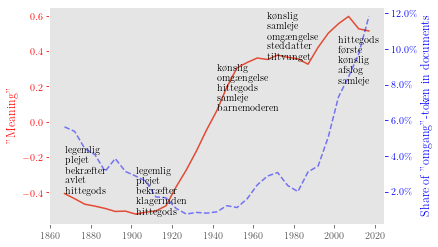

In [10]:

%matplotlib inline
from matplotlib import rcParams


from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

plt.style.use('ggplot')
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "Helvetica"
})


pca = PCA(1)
pca.fit(query_word_embedding_through_time)
pca.transform(query_word_embedding_through_time)
time_considered = [index for index in range(1867,2022,5)]
one_dimensional_embedding = [x[0] for x in pca.transform(query_word_embedding_through_time).tolist()]
one_dimensional_embedding_plot = list(zip(one_dimensional_embedding,time_considered))
plt.clf
fig = plt.figure()
ax = plt.axes()
ax.plot(time_considered,one_dimensional_embedding)
ax.set_ylabel('"Meaning"',color="red")
ax.tick_params(axis='y', colors='red')
ax.spines['top'].set_visible(False)
# ax.set_title(f'Evolution of meaning for "{query_word}"')

annotate_year = [1869,1904,1944, 1969, 2004]
years = range(1869,2019,5)
annotate_year_index = [years.index(x) for x in annotate_year]

for year,year_index in enumerate(annotate_year_index):
    if one_dimensional_embedding_plot[year_index][0] > 0.8 * max(one_dimensional_embedding_plot)[0]:
        y = one_dimensional_embedding_plot[year_index][0] - 0.3 * (max(one_dimensional_embedding_plot)[0] - min(one_dimensional_embedding_plot)[0])
    else:
        y = one_dimensional_embedding_plot[year_index][0]

    ax.annotate(text=top_5_most_sim[year_index],
                xy=(one_dimensional_embedding_plot[year_index][1],y),
                xycoords ="data")
ax.grid(False)
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(df_doc_share.loc[:,query_word],color="blue", linestyle="--",alpha=0.5)
ax2.set_ylabel(f'Share of "{query_word}"-token in documents',color="blue")
ax2.tick_params(axis='y', colors='blue')

ax2.grid(False)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())



fig.savefig("../../data/plots/one_dimensional_meaning_test.pdf")


## The words that changed the most

In [11]:
from scipy import spatial

In [12]:
INTERVAL = [1867, 1920, 1950, 1980, 1995, 2010, 2022]
#Generate inteverals based on input
interval_range = [range(x[0],x[1]) for x in zip(INTERVAL[:-1],INTERVAL[1:])] 
timespans = list(zip(INTERVAL[:-1],INTERVAL[1:]))
timespans = [pd.Interval(left=x,right=y) for x,y in timespans]
df_term_freq_custom_time_interval = df_term_freq.transpose().reset_index() \
                                                            .groupby(
                                                                pd.cut(
                                                                    df_term_freq.transpose().reset_index()["level_0"], bins=pd.IntervalIndex(timespans),include_lowest=True)).sum()

emb_first = aw2v_embeddings[0]
emb_last= aw2v_embeddings[-1]
cos_distances = []
for word_idx in range(len(emb_first)):
    word = emb_first.index_to_key[word_idx]
    if word in df_term_freq_custom_time_interval.columns:
        if all(df_term_freq_custom_time_interval[word] > 0): 
            cos_distances.append(spatial.distance.cosine(emb_first.get_vector(word),emb_last.get_vector(word)))
        else:
            cos_distances.append(pd.NA)
    else:
            cos_distances.append(pd.NA)
df_changes = pd.DataFrame(zip(cos_distances,emb_first.key_to_index.keys(),emb_first.key_to_index.values()),columns=["Distance","Word","ID"]).sort_values("Distance",ascending=False)
df_changes.dropna()[:10]

,Distance,Word,ID
1761,0.928062,omgang,1761
879,0.90595,fr,879
3454,0.90505,aa,3454
8081,0.90292,lo,8081
3993,0.897931,ansattes,3993
2276,0.890374,tæring,2276
861,0.889254,mænd,861
4108,0.888785,islandske,4108
5024,0.887906,stødende,5024
219,0.886671,ere,219


### Obtaining sentences where the word is used

In [13]:
query_word = "ere"
timespan = range(1867,1950)
df_q = df.loc[(df["words"].progress_apply(lambda x: query_word in x)) & (df["year"].astype(int).isin(timespan))].copy()
df_q["sentences_with_q_word"] = df_q["sentences"].progress_apply(lambda x: [y for y in x if query_word in list(gensim.utils.tokenize(y, lowercase=True))])
df_q_shuffled = df_q.loc[:,["id_verdict","sentences_with_q_word"]].sample(frac=1,random_state=1)


NameError: name 'df' is not defined

In [17]:
aw2v_embeddings

## Store keyedvectors

In [19]:
interval_range = [range(x[0],x[1]) for x in zip(INTERVAL[:-1],INTERVAL[1:])] 
timespans = list(zip(INTERVAL[:-1],INTERVAL[1:]))
timespans = [f"{x}_{y}" for x,y in timespans]


['1867_1920', '1920_1950', '1950_1980', '1980_1995', '1995_2010', '2010_2022']

In [29]:
dw2v_embeddings[0].shape

(22597, 300)